# Salto de potencial sob controle difusional - condição de Cottrell

Assumindo a transferência reversível de 1 elétron:
$$
\begin{equation*}
\text{O} + \text{ne}^- \rightleftharpoons \text{R}
\end{equation*}
$$

Assumindo eletrodo planar:

\begin{equation}
  \frac{\partial c_O}{\partial \tau} = D_O \frac{\partial^2 c_O}{\partial y^2} \quad \text{para} \quad  0\le \tau \le \tau_s \quad \text{e} \quad 0 \le y \le 6 \sqrt{D \tau_s}
\end{equation}
com as seguintes condições iniciais e de contorno:
\begin{equation}
C_O(y,0) = C_O^* 
\end{equation}
\begin{equation*}
\lim_{y \to \infty} C_O(y,\tau) = C_O^*
\end{equation*}
\begin{equation*}
C_O(0,\tau) = 0 \: \text{para} \, \tau>0
\end{equation*}

Definindo as seguintes transformações de variáveis:

\begin{equation*}
x=\frac{y}{\sqrt{D \tau_s}}
\end{equation*}

\begin{equation*}
t=\frac{\tau}{\tau_s}
\end{equation*}
\begin{equation*}
c=\frac{C_O}{C_O^*}
\end{equation*}


As equações ficam:
\begin{equation} 
\tag{1.0}
\frac{\partial c}{\partial t} =  \frac{\partial^2 c}{\partial x^2} \quad \text {para} \quad 0 \le t \quad \text{e} \quad 0 \le x \le 6 
\end{equation}

E as condições iniciais e de contorno ficam:
\begin{equation}
\tag{1.1}
c(x,0)=1
\end{equation}
\begin{equation}
\tag{1.2}
\lim_{x \to \infty} c(x,t)=1
\end{equation}
\begin{equation}
\tag{1.3}
c(0,t) = 0 \: \text{para} \, t>0
\end{equation}

A solução para a concentração é:
\begin{equation*}
\tag{2.0}
c(x,t)= 1-erfc \left ( \frac{x}{2\sqrt{t}} \right )
\end{equation*}

A densidade de corrente é limitada pelo fluxo difusional, logo:
\begin{equation*}
j(\tau) = nFD \left ( \frac{\partial C_O}{\partial y} \right )_{y=0} = nFD\frac{C_O^*}{\sqrt{D\tau}} \left ( \frac{\partial c}{\partial x} \right )_{x=0}
\end{equation*}

Definindo a corrente adimensional como $i(t)=\frac{j(\tau)}{nFD} \frac{\sqrt{D\tau}}{C_O^*}$ e derivando a expressão da concentração:
\begin{equation*}
\tag{3.0}
i(t)=\frac{1}{\sqrt{\pi t}}
\end{equation*}

Iniciamos importando as bibliotecas do pybamm e do python necessárias:


In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
import math
from scipy import special

## Definindo o modelo

Definindo a variável do modelo e a qual domínio ela pertence:

In [2]:
model = pybamm.BaseModel()

c = pybamm.Variable("Concentration", domain="electrolyte")

As equações são definidas em termos do fluxo e do divergente e adicionadas ao dicionário `model.rhs`

In [3]:
N = - pybamm.grad(c)  # define o fluxo
dcdt = -pybamm.div(N)  # define o lado esquerdo da equação diferencial (eq 1.0)

model.rhs = {c: dcdt}  # adiciona ao dicionário rhs

Introduzindo as condições iniciais e de contorno:

In [4]:
# concdição inicial eq 1.1
model.initial_conditions = {c: pybamm.Scalar(1)}

# boundary conditions
lbc = pybamm.Scalar(0) # condição de cottrel eq 1.3
rbc = pybamm.Scalar(1) # difusão semi-infintia eq 1.2
model.boundary_conditions = {c: {"left": (lbc, "Dirichlet"), "right": (rbc, "Dirichlet")}} # adiciona ao dicionário

Adicionando as variáveis de interesse ao dicionário `model.variables`. A implementar: cálculo da corrente.

In [5]:
model.variables = {"Concentration": c, "Flux": N} #variáveis disponíveis na solução

## Usando o modelo

### Definindo a geometria e a malha

As variáveis espaciais são definidas independentemente das variáveis do modelo. O domínio 1D varia no intervalo $0 \le x \le 6$.

In [6]:
# define a geometria
x = pybamm.SpatialVariable(
    "x", domain=["electrolyte"], coord_sys="cartesian"
)
geometry = {"electrolyte": {x: {"min": pybamm.Scalar(0), "max": pybamm.Scalar(6)}}}

Criando uma malha uniforme. A implementar : malha com expansão exponencial. (ver descrição abaixo)

In [7]:
# construção da malha
submesh_types = {"electrolyte": pybamm.Uniform1DSubMesh}
var_pts = {x: 400} # número de elementos da malha
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)

Example of meshes that do require parameters include the `pybamm.Exponential1DSubMesh` which clusters points close to one or both boundaries using an exponential rule. It takes a parameter which sets how closely the points are clustered together, and also lets the users select the side on which more points should be clustered. For example, to create a mesh with more nodes clustered to the right (i.e. the surface in the particle problem), using a stretch factor of 2, we pass an instance of the exponential submesh class and a dictionary of parameters into the `MeshGenerator` class as follows: `pybamm.MeshGenerator(pybamm.Exponential1DSubMesh, submesh_params={"side": "right", "stretch": 2})`

Discretizando por Volumes Finito. A testar: Elementos finitos.

In [8]:
spatial_methods = {"electrolyte": pybamm.FiniteVolume()}
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(model);

### Resolvendo o modelo

O Solver ScipySolver é escolhido. Outras opções?. Definindo a malha uniforme no tempo.  

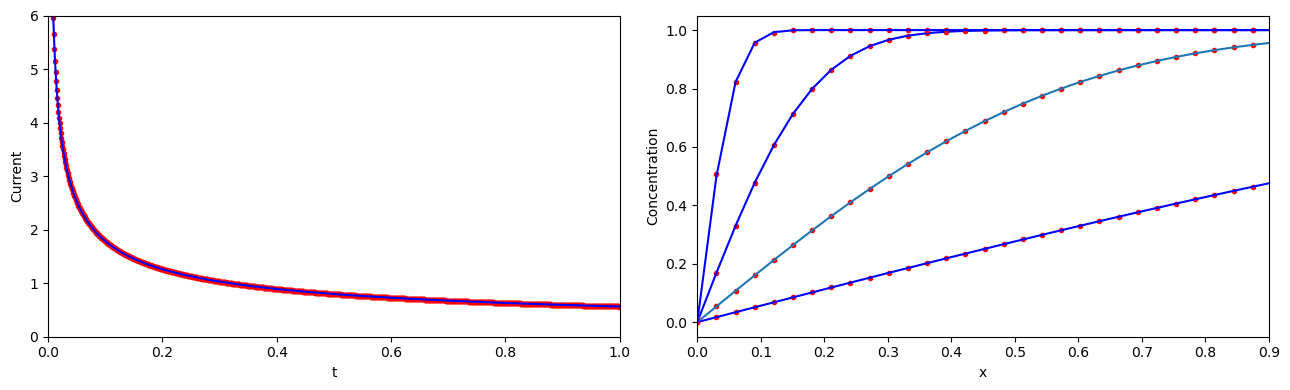

In [10]:
# solução
solver = pybamm.ScipySolver()
t = np.linspace(0.00001, 1, 1000) # malha uniforme no tempo. única opção? problemas de stiff?
solution = solver.solve(model, t)

# pós processamento
c = solution["Concentration"] # c acessível em qualquer x e qualquer t por interpolação
N = solution["Flux"] # idem para N

# figuras
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

#perfis de concentração teórico e calculado
def can(t):
    return 1 - special.erfc(x/(2*np.sqrt(t))) # solução analítica
x = np.linspace(0, 6, 200)
ax2.plot(x, c(t=1, x=x),"r.",x, can(1),"b",x,c(t=0.1, x=x),"r.",x, can(.1),
         x, c(t=0.01, x=x),"r.",x, can(.01),"b",x, c(t=0.001, x=x),"r.",x, can(.001),"b")
ax2.set_xlabel("x")
ax2.set_ylabel("Concentration")
ax2.set_xlim([0,0.9])

#theoretical and numerical current
def ian(t):
    return 1/np.sqrt(np.pi*t) # solução analítica, indefinida para t=0
ax1.plot(solution.t,-N(solution.t,x=0),"r.",solution.t,ian(solution.t),"b")
ax1.set_xlabel("t")
ax1.set_ylabel("Current")
ax1.set_xlim([0,1])
ax1.set_ylim([0,6])
plt.tight_layout()
plt.show()